Shape of the dataset (115986, 56)
Dataset variable types: Year_2023        int32
Year_2024        int32
Month_1          int32
Month_2          int32
Month_3          int32
Month_4          int32
Month_5          int32
Month_6          int32
Month_7          int32
Month_8          int32
Month_9          int32
Month_10         int32
Month_11         int32
Month_12         int32
Day_1            int32
Day_2            int32
Day_3            int32
Day_4            int32
Day_5            int32
Day_6            int32
Day_7            int32
Day_8            int32
Day_9            int32
Day_10           int32
Day_11           int32
Day_12           int32
Day_13           int32
Day_14           int32
Day_15           int32
Day_16           int32
Day_17           int32
Day_18           int32
Day_19           int32
Day_20           int32
Day_21           int32
Day_22           int32
Day_23           int32
Day_24           int32
Day_25           int32
Day_26           int32
Day_27           int32

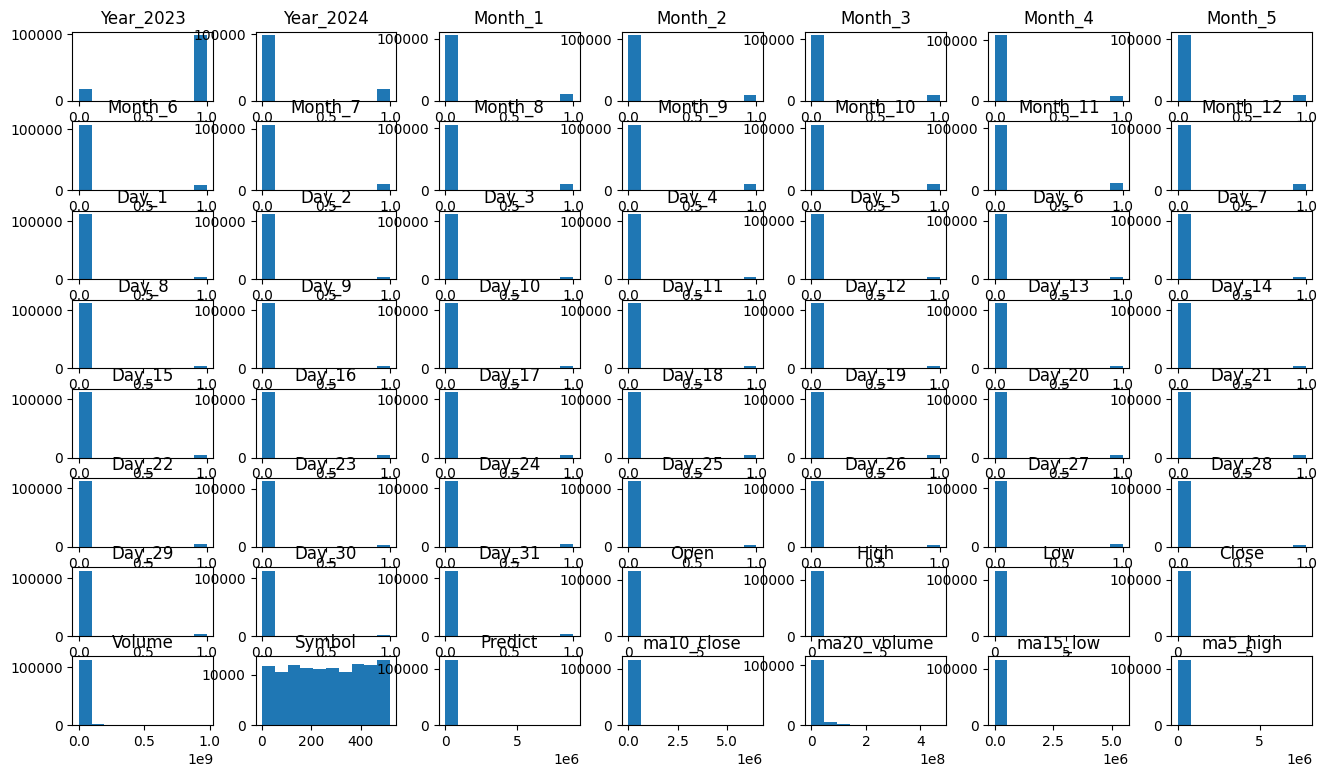

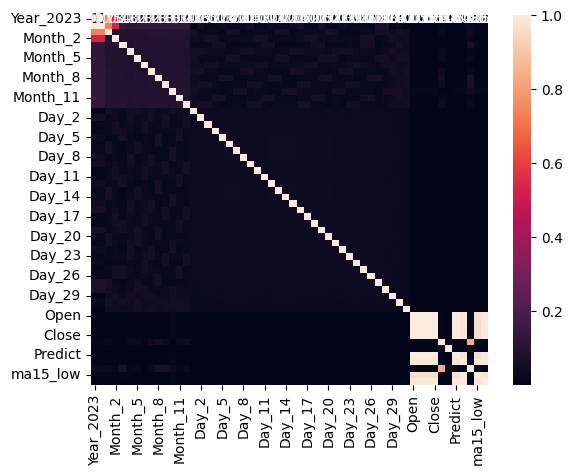

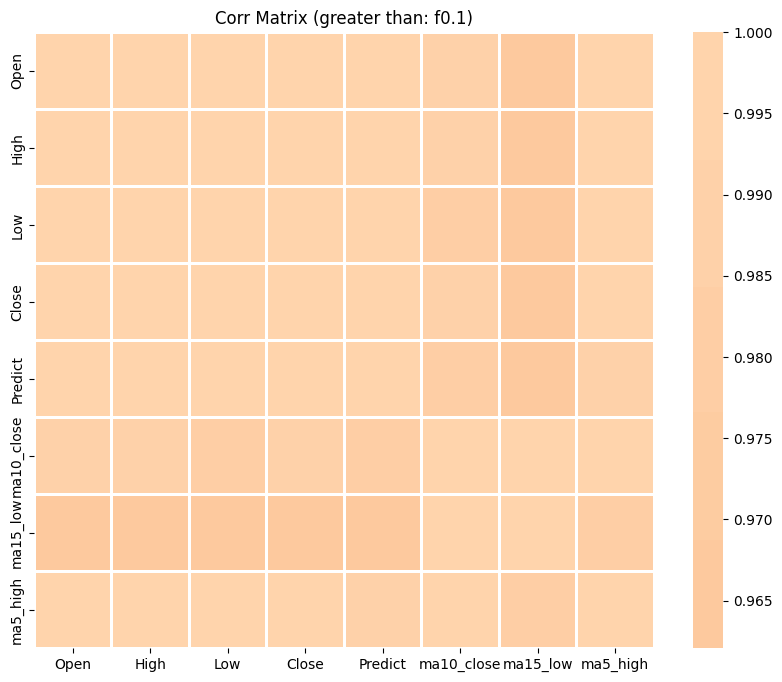







Linear Regression R^2 Score: 0.9896478015114757
Linear Regression Time: 0.24275827407836914
Decision Tree R^2 Score: 0.9684145297897362
Decision Tree Time: 3.3356189727783203
Gradient Boosting R^2 Score: 0.980044839228774
Gradient Boosting Time: 57.01185703277588
Extra Trees R^2 Score: 0.9799040856467529
Extra Trees Time: 208.43499040603638
The Best Model: Linear Regression
R^2 Score of the Best Model: 0.9896478015114757






Linear Regression CV - r2score :  0.9924669829156466
Linear Regression test-r2score :  0.9896478015114757
Linear Regression: 2.9362480640411377 sn

Decision Tree CV - r2score :  0.9862590210669587
Decision Tree test-r2score :  0.9720710786673780
Decision Tree: 31.238553285598755 sn

Gradient Boosting CV - r2score :  0.9888780270802631
Gradient Boosting test-r2score :  0.9802691259384611
Gradient Boosting: 559.0018594264984 sn

Extra Trees CV - r2score :  0.9931906067264673
Extra Trees test-r2score :  0.9801706587620036
Extra Trees: 1952.6123065948486 sn

25

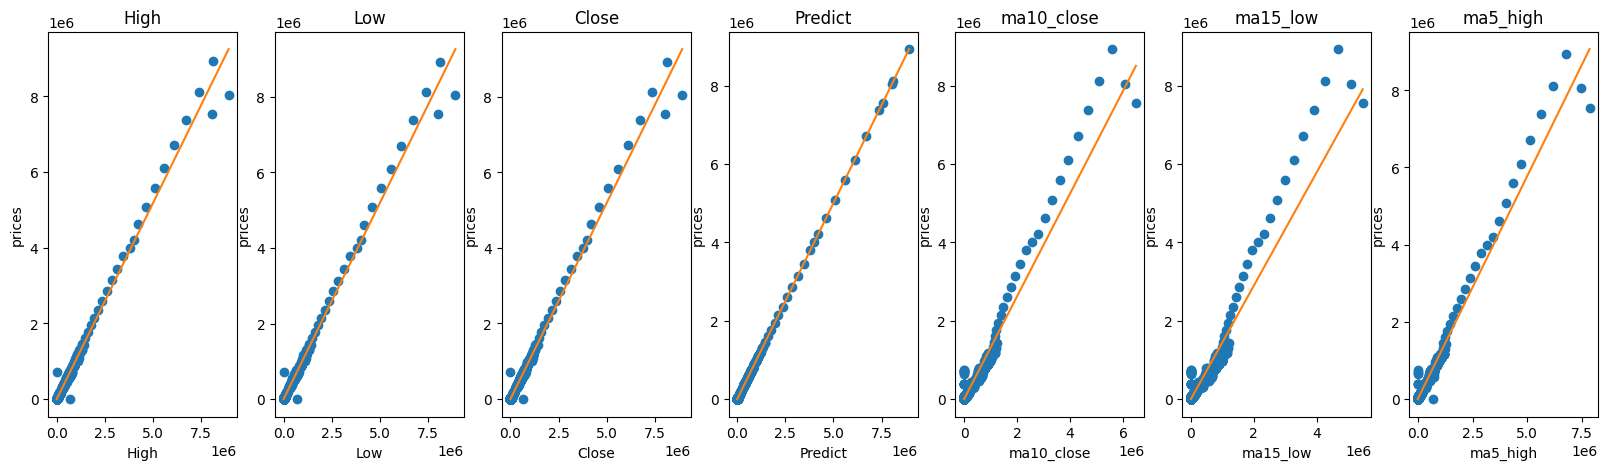

<Figure size 2000x500 with 0 Axes>

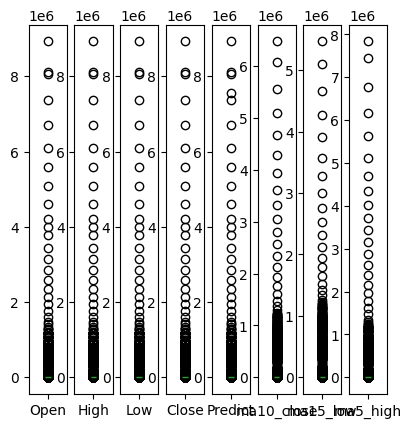

In [1]:
"""
Created on Fri Mar 22 17:15:38 2024

@author: İrem Beyza Gül
"""


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score


data = pd.read_csv("originaldata.csv")


imputer = SimpleImputer(missing_values=np.nan, strategy="constant", fill_value=0)
datas = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)
datason = datas.loc[:, (data != 0).any(axis=0)]
datason.drop(datason.columns[-1], axis=1, inplace=True)

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
symbol_encoded = label_encoder.fit_transform(datason['Symbol'])
symbol_encoded_df = pd.DataFrame(symbol_encoded, columns=['Symbol'])
datason_encoded = pd.concat([datason.drop('Symbol', axis=1), symbol_encoded_df], axis=1)


datason_encoded['Date'] = pd.to_datetime(datason_encoded['Date'])
datason_encoded['Year'] = datason_encoded['Date'].dt.year
datason_encoded['Month'] = datason_encoded['Date'].dt.month
datason_encoded['Day'] = datason_encoded['Date'].dt.day


datason_encoded.drop('Date', axis=1, inplace=True)
datason_encoded_onehot = pd.get_dummies(datason_encoded[['Year', 'Month', 'Day']], columns=['Year', 'Month', 'Day']).astype(int)
result = pd.concat([datason_encoded_onehot, datason_encoded.drop(['Year', 'Month', 'Day'], axis=1)], axis=1)

predict_column = result.pop('Predict')  


result['Predict'] = predict_column

result['ma10_close'] = result.groupby('Symbol')['Close'].transform(lambda x: x.rolling(window=10).mean())
result['ma20_volume'] = result.groupby('Symbol')['Volume'].transform(lambda x: x.rolling(window=20).mean())
result['ma15_low'] = result.groupby('Symbol')['Low'].transform(lambda x: x.rolling(window=15).mean())
result['ma5_high'] = result.groupby('Symbol')['High'].transform(lambda x: x.rolling(window=5).mean())
result = result.fillna(0)

print("Shape of the dataset",result.shape)
print("Dataset variable types:",result.dtypes)
print("First 10 rows of the dataset")
print(result.head(10))
print("Statistical data of the dataset")
description=result.describe()
print(description)
result.hist(bins=10,figsize=(16,9),grid=False);

print("The correlation coefficient of the variables in the data set with each other")
corr=np.abs(result.corr(method='pearson'))
plt.figure()
sns.heatmap(corr, annot = True)


predict_sutununun_indeksi = result.columns.get_loc("Predict")

selected_column_name = result.columns[predict_sutununun_indeksi]

column_correlations = corr[selected_column_name]

threshold = 0.1

filtered_correlations = column_correlations[abs(column_correlations) >= threshold]

selected_columns = filtered_correlations.index

filtered_corr = corr.loc[selected_columns, selected_columns]

plt.figure(figsize=(10, 8))
sns.heatmap(filtered_corr, annot=False, fmt=".2f", linewidths=0.9, center=0)
plt.title(f"Corr Matrix (greater than: f{threshold})")
plt.show()

new_df = result[selected_columns].copy()



features =new_df.drop(new_df.columns[0], axis=1)
predict = result.iloc[:,predict_sutununun_indeksi]

plt.figure(figsize=(20, 5))
for i, col in enumerate(features.columns):
    
    plt.subplot(1, len(features.columns), i+1)
    x = new_df[col]
    y = predict
    plt.plot(x, y, 'o')
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('prices')

plt.figure(figsize=(20, 5))
new_df.plot(kind='box', subplots=True, layout=(1,11), sharex=False, sharey=False)
print("\n")
print("\n")
print("\n")

#REGRESSİON
x = result.iloc[:,0:-1].values 
y = result.iloc[:,-1].values 
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=47)


sc=StandardScaler()
X_train = sc.fit_transform(x_train)
X_test = sc.transform(x_test)

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.metrics import r2_score
import time
from sklearn.model_selection import StratifiedKFold,cross_val_score,train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
# Linear Regression

start_time = time.time()
model = LinearRegression()
model.fit(X_train, y_train)
y_pred_lr = model.predict(X_test)
r2_lr = r2_score(y_test, y_pred_lr)
lr_time = time.time() - start_time
print("Linear Regression R^2 Score:", r2_lr)
print("Linear Regression Time:", lr_time)

# Decision Tree
start_time = time.time()
model = DecisionTreeRegressor()
model.fit(X_train, y_train)
y_pred_dtc = model.predict(X_test)
r2_dtc = r2_score(y_test, y_pred_dtc)
dtc_time = time.time() - start_time
print("Decision Tree R^2 Score:", r2_dtc)
print("Decision Tree Time:", dtc_time)

# Gradient Boosting
start_time = time.time()
model = GradientBoostingRegressor()
model.fit(X_train, y_train)
y_pred_gbr = model.predict(X_test)
r2_gbr = r2_score(y_test, y_pred_gbr)
gbr_time = time.time() - start_time
print("Gradient Boosting R^2 Score:", r2_gbr)
print("Gradient Boosting Time:", gbr_time)

# Extra Trees
start_time = time.time()
model = ExtraTreesRegressor()
model.fit(X_train, y_train)
y_pred_etr = model.predict(X_test)
r2_etr = r2_score(y_test, y_pred_etr)
etr_time = time.time() - start_time
print("Extra Trees R^2 Score:", r2_etr)
print("Extra Trees Time:", etr_time)


models = {
    "Linear Regression": r2_lr,
    "Decision Tree": r2_dtc,
    "Gradient Boosting": r2_gbr,
    "Extra Trees": r2_etr
}

best_model = max(models, key=models.get)
best_r2_score = models[best_model]

print("The Best Model:", best_model)
print("R^2 Score of the Best Model:", best_r2_score)
print("\n")
print("\n")
print("\n")
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import KFold, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.linear_model import LinearRegression
import time
import pickle

models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "Extra Trees": ExtraTreesRegressor()
}

num_folds = 10
results = {}



start_time0 = time.time()
for name, model in models.items():
    start_time = time.time()
    
    kfold = KFold(n_splits=num_folds, shuffle=True, random_state=47)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring="r2")
    
    mean_r2score = cv_results.mean()
    
    model.fit(X_train, y_train)
    test_r2score = model.score(X_test, y_test)
    results[name] = test_r2score
    
    print(f"{name} CV - r2score :  {mean_r2score:.16f}")
    print(f"{name} test-r2score :  {test_r2score:.16f}")
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"{name.ljust(8)}: {elapsed_time} sn\n")
    
end_time0 = time.time()
elapsed_time = end_time0 - start_time0
print(f"{elapsed_time} sn")

print("\n")

best_model = max(results, key=results.get)
print("Best Model according to the test data: ", best_model)

models_dict = dict(models)

best_model_instance = models_dict.get(best_model)
best_model_instance.fit(X_train, y_train)

test_r2score = best_model_instance.score(X_test, y_test)
print("Test set r2 score (best model):", test_r2score)

y_pred = best_model_instance.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("\nEvaluation metrics for the best model ({}):".format(best_model))
print("Test set r2 score:", test_r2score)
print("Test set MSE (Mean Square Error):", mse)
print("Test set MAE (Mean Absolute Error):", mae)


with open('en_iyi_model.pkl', 'wb') as f:
    pickle.dump(best_model_instance, f)
